### This exercise is focused on prediction.  As such, visualization is minimal, as is data exploration (Kaggle shows the distribution of each variable, which is helpful).  I ended up working the data both with and without missing values, figuring that ultimately I needed predictive capability WITH missing values.
### Random Forest did pretty well, though unsurprisingly the best was XGBoost, at 80%, which seems good when trying to predict housing prices.
### There are actually 2 data sets on Kaggle, and the other is twice as big, but missing some columns.  I did that one as well, getting to nearly 74% with XGBoost.  Tradeoffs in either direction.
### Having worked in construction over the years, I'm doubtful that we could squeeze much more prediction out of the data available.  I can quickly think of a number of factors that are important but unaccounted for, things like the quality of the door and window package, or roof quality.  General fit and finish (craftsman grade vs. a fast subdivision?).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

%matplotlib inline

In [2]:
train = pd.read_csv("Melbourne_housing.csv")
train.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0


In [3]:
# do some cleanup
drops = ['Lattitude', 'Longtitude', 'Propertycount', 'Address', 'Postcode', 'Bedroom2', 'SellerG']
train.drop(drops, 1, inplace=True)
train.rename({'CouncilArea':'Council', 'Regionname':'Region', 'YearBuilt':'Year',
              'Landsize':'LandArea', 'BuildingArea':'HomeArea'}, axis=1, inplace=True)
train.head(2)

,Suburb,Rooms,Type,Price,Method,Date,Distance,Bathroom,Car,LandArea,HomeArea,Year,Council,Region
0,Abbotsford,2,h,NaN,SS,3/09/2016,2.5,1.0,1.0,126.0,NaN,NaN,Yarra City Council,Northern Metropolitan
1,Abbotsford,2,h,1480000.0,S,3/12/2016,2.5,1.0,1.0,202.0,NaN,NaN,Yarra City Council,Northern Metropolitan


In [4]:
train.isnull().sum()

Suburb          0
Rooms           0
Type            0
Price        7610
Method          0
Date            0
Distance        1
Bathroom     8226
Car          8728
LandArea    11810
HomeArea    21115
Year        19306
Council         3
Region          3
dtype: int64

### There is a lot of missing data.  I have to drop all rows where Price is missing, as that's what I'm trying to predict.  I'll massage the others as best I can.  I'll also drop the few missing from Distance, Council, and Region.  Numeric and graphical methods are both necessary, as all missing values aren't obvious graphically.

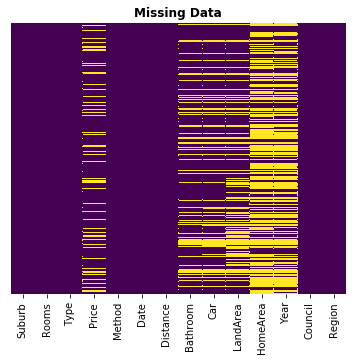

In [5]:
f, axes = plt.subplots(1, 1, figsize=(6,5))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False,
            cmap='viridis', ax=axes).set_title('Missing Data', fontweight='bold')
plt.show()

In [6]:
train.dropna(subset=['Price', 'Distance', 'Council', 'Region'], inplace=True)

In [7]:
print("Total rows in set after dropping missing Prices:", train.shape[0])
print("Rows remaining if all NaN's were dropped:", train.dropna().shape[0])
train.isnull().sum()

Total rows in set after dropping missing Prices: 27244
Rows remaining if all NaN's were dropped: 8895


Suburb          0
Rooms           0
Type            0
Price           0
Method          0
Date            0
Distance        0
Bathroom     6444
Car          6821
LandArea     9262
HomeArea    16588
Year        15160
Council         0
Region          0
dtype: int64

In [8]:
# Get more useful datetimes
train['Date'] = pd.to_datetime(train['Date'])
train['Date'] = train['Date'].dt.month

In [9]:
# Outliers that will throw things off
train['Rooms'].value_counts()

3     11956
2      6785
4      5918
5      1209
1      1196
6       137
7        20
8        14
10        5
12        2
9         1
16        1
Name: Rooms, dtype: int64

In [10]:
train['Car'].value_counts()

2.0     9367
1.0     7400
0.0     1251
3.0     1234
4.0      907
5.0      113
6.0      105
7.0       19
8.0       18
10.0       5
9.0        2
11.0       1
18.0       1
Name: Car, dtype: int64

In [11]:
# get rid of the really big ones
train = train[(train['Rooms'] < 7) & (train['Car'] < 7)]

In [12]:
train.nunique()

Suburb       338
Rooms          6
Type           3
Price       2592
Method         5
Date          12
Distance     211
Bathroom       8
Car            7
LandArea    1538
HomeArea     656
Year         150
Council       33
Region         8
dtype: int64

### I'm converting the dates to just months, as I believe they will be more predictive.  Also I'll convert the categoricals to a more useful form.

In [13]:
convert = ['Method', 'Type', 'Suburb', 'Council', 'Region']
le = LabelEncoder()
for name in convert:
    train[name] = le.fit_transform(train[name])

In [14]:
# This is looking a lot better
train.head(2)

,Suburb,Rooms,Type,Price,Method,Date,Distance,Bathroom,Car,LandArea,HomeArea,Year,Council,Region
1,0,2,0,1480000.0,1,3,2.5,1.0,1.0,202.0,NaN,NaN,31,2
2,0,2,0,1035000.0,1,4,2.5,1.0,0.0,156.0,79.0,1900.0,31,2


### First let's play around with the small subset of the data containing no NaN's.  That should have a lot of predictive power, but it's also fairly useless: What happens when we need a prediction for a house that's missing something?

In [15]:
no_nan = pd.DataFrame(train.dropna())

In [16]:
X = no_nan.drop(columns='Price')
y = no_nan['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Try just a plain tree

In [17]:
dcr = tree.DecisionTreeRegressor()
dcr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [18]:
predictions = dcr.predict(X_test)

In [19]:
dcr.score(X_test, y_test)

0.52874135910195

### Now a Random Forest, tuned a bit

In [20]:
rfr = RandomForestRegressor(n_estimators=60, max_depth=10)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
predictions = rfr.predict(X_test)

### Pretty good

In [22]:
print(rfr.score(X_test, y_test))
cross = cross_val_score(rfr, X_train, y_train, cv=5)
print(cross)
print("Cross Validation Mean: ", cross.mean())

0.8275732692508104
[0.7930632  0.80486159 0.76643083 0.71452083 0.79164395]
Cross Validation Mean:  0.7741040777235738


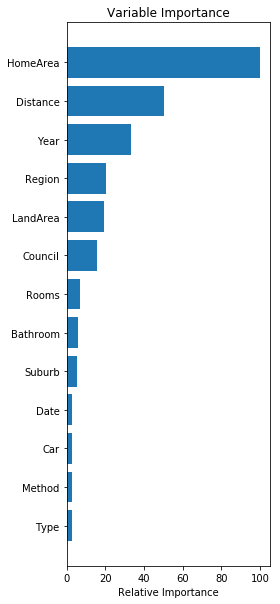

In [23]:
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Now XGBoost, also tuned a bit

In [24]:
# I went through a bunch of iterations here to get to this tuning.
# Wanted to hand-tune rather than use GridSearch
xgb = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=220)
xgb.fit(X_train, y_train)
print(xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=220,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [25]:
print(xgb.score(X_test, y_test))
cross = cross_val_score(xgb, X_train, y_train, cv=5)
print(cross)
print("Cross Validation Mean: ", cross.mean())

0.8512554716589515
[0.83331063 0.84051893 0.78998596 0.76375318 0.81259361]
Cross Validation Mean:  0.8080324628693656


### That's pretty good; however, it's also fairly useless because it's ignoring anything with missing values.  Now let's go with NaN's present in the data.

In [26]:
# Use the data containing NaN's now
X = train.drop(columns='Price')
y = train['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
xgb = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=220, colsample_bylevel=0.4)
xgb.fit(X_train, y_train)
print(xgb)
predictions = xgb.predict(X_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=220,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


### This is actually quite good: basically 80% predictive power

In [28]:
print(xgb.score(X_test, y_test))
cross = cross_val_score(xgb, X_train, y_train, cv=5)
print(cross)
print("Cross Validation Mean: ", cross.mean())

0.8151240287656984
[0.77688549 0.81783727 0.82338987 0.77732852 0.80692704]
Cross Validation Mean:  0.8004736385145638


In [29]:
print("Accuracy: %.2f%% (%.2f%%)" % (cross.mean()*100, cross.std()*100))

Accuracy: 80.05% (1.98%)


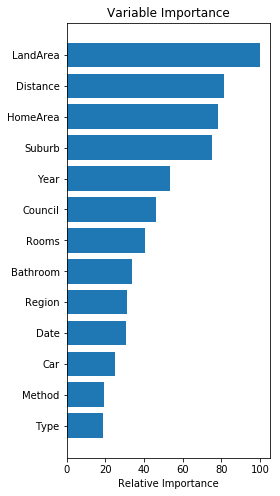

In [30]:
feature_importance = xgb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()